In [133]:
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.utils import resample
from sklearn import metrics
import itertools

In [157]:
cities = ['Ahmedabad','Bangalore','Chennai','Delhi','Hyderabad','Kolkata','Mumbai','Pune']

for index,city in enumerate(cities):
    path = f'./data/{city}_rent.csv'
    if index == 0:
        data = pd.read_csv(path)
        data['city'] = list(itertools.repeat(city,len(data)))
    else:
        df = pd.read_csv(path)
        df['city'] = list(itertools.repeat(city,len(df)))
        data = pd.concat([data,df])


In [158]:
data = data.reset_index().drop('index',axis=1)
data

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city
0,OWNER,2.0,BHK,Apartment,Bodakdev,"20,000",1450.0,Furnished,2 bathrooms,Ahmedabad
1,OWNER,1.0,RK,Studio Apartment,CG Road,"7,350",210.0,Semi-Furnished,1 bathrooms,Ahmedabad
2,OWNER,3.0,BHK,Apartment,Jodhpur,"22,000",1900.0,Unfurnished,3 bathrooms,Ahmedabad
3,OWNER,2.0,BHK,Independent House,Sanand,"13,000",1285.0,Semi-Furnished,2 bathrooms,Ahmedabad
4,OWNER,2.0,BHK,Independent House,Navrangpura,"18,000",1600.0,Furnished,2 bathrooms,Ahmedabad
...,...,...,...,...,...,...,...,...,...,...
196833,OWNER,1.0,BHK,Apartment,Chinchwad,"13,250",650.0,Semi-Furnished,1 bathrooms,Pune
196834,OWNER,1.0,RK,Studio Apartment,Wadgaon Sheri,"7,000",350.0,Unfurnished,1 bathrooms,Pune
196835,OWNER,1.0,BHK,Apartment,Kothrud,"8,500",389.0,Semi-Furnished,1 bathrooms,Pune
196836,AGENT,1.0,BHK,Apartment,Wakad,"16,500",670.0,Semi-Furnished,2 bathrooms,Pune


In [159]:
data = data.drop_duplicates()

In [160]:
print(f"Features: {', '.join(data.columns)}")
print(f'Numero de filas: {data.shape[0]}')
print(f'Numero de Columnas: {data.shape[1]}')

Features: seller_type, bedroom, layout_type, property_type, locality, price, area, furnish_type, bathroom, city
Numero de filas: 109532
Numero de Columnas: 10


In [161]:
df_dtypes = pd.merge(data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         data.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
df_dtypes

,index,missing_value,feature_type
0,city,0,object
1,bedroom,3,float64
2,layout_type,3,object
3,property_type,3,object
4,price,3,object
5,area,3,float64
6,furnish_type,3,object
7,locality,4,object
8,seller_type,6,object
9,bathroom,1593,object


In [162]:
target = 'price'
categorical_columns = ['city','layout_type','property_type','furnish_type','locality','seller_type','bathroom']
continuous_columns = ['bedroom','area']

Eliminar las filas que tengan el target null

In [163]:
data = data.dropna(subset=[target])

In [164]:
df_dtypes = pd.merge(data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         data.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
df_dtypes

,index,missing_value,feature_type
0,bedroom,0,float64
1,layout_type,0,object
2,property_type,0,object
3,price,0,object
4,area,0,float64
5,furnish_type,0,object
6,city,0,object
7,locality,1,object
8,seller_type,3,object
9,bathroom,1590,object


#### Hay pocos nulls en relacion a la cantidad de registros por lo que elimino todo el registro

In [165]:
data = data.dropna()

La variable objetivo (Price) aparece como object y deberia ser float

In [166]:
data[target]= data[target].str.replace(',','',regex=False).astype(float)

### Analizar las distribuciones de cada columna

<Figure size 432x288 with 0 Axes>

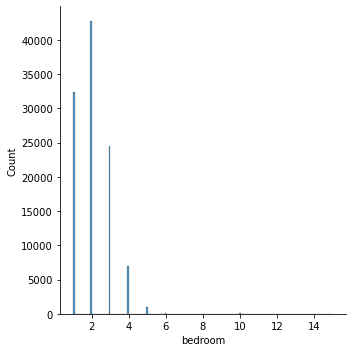

<Figure size 432x288 with 0 Axes>

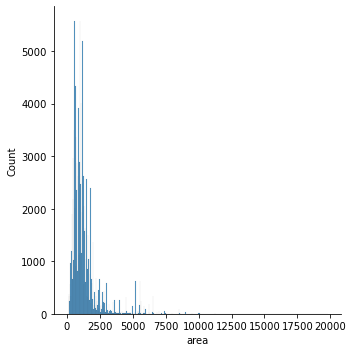

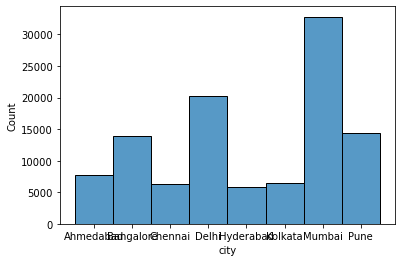

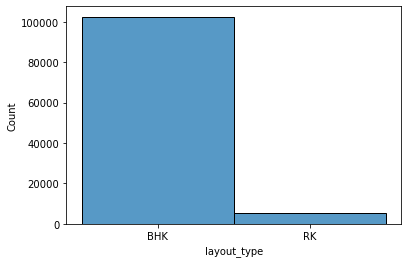

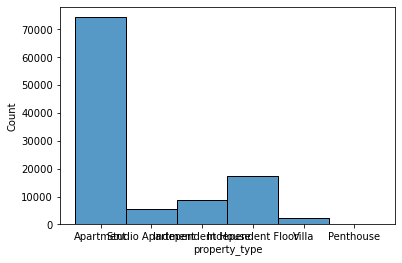

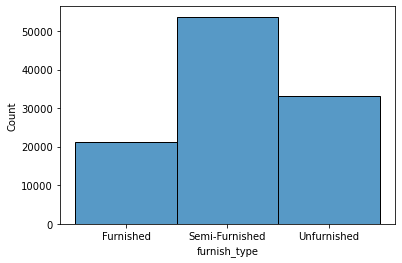

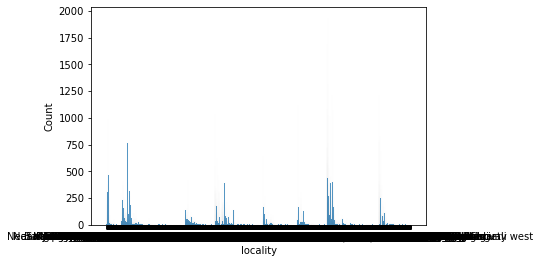

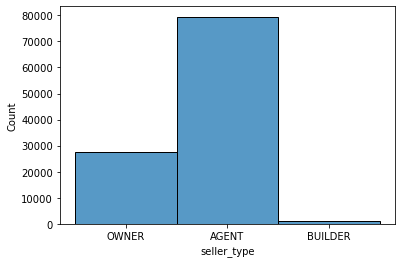

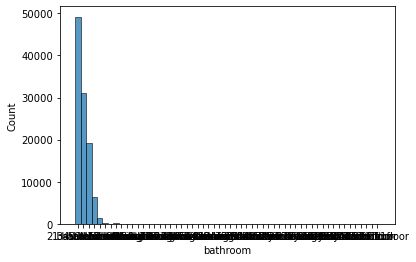

In [167]:
for column in continuous_columns:
    plt.figure()
    sns.displot(x=column, data=data)
    
for column in categorical_columns:
    plt.figure()
    sns.histplot(x=column, data=data,discrete=True)

In [168]:
data['bathroom'].value_counts()

2 bathrooms                 49199
1 bathrooms                 30979
3 bathrooms                 19166
4 bathrooms                  6442
5 bathrooms                  1377
6 bathrooms                   269
East facing                   107
7 bathrooms                    59
North facing                   48
8 bathrooms                    41
9 bathrooms                    36
West facing                    27
10 bathrooms                   25
NorthEast facing               20
Grfloor                        17
SouthWest facing               12
NorthWest facing               12
1 of 4floor                    10
SouthEast facing                8
2 of 4floor                     7
South facing                    6
12 bathrooms                    5
15 bathrooms                    5
16 bathrooms                    4
14 bathrooms                    4
Family only                     3
2 of 7floor                     3
3 of 4floor                     3
1 of 3floor                     3
3 of 3floor   

In [169]:
data['locality'].value_counts()

Thane West           1936
Andheri East         1691
Chembur              1315
Wagholi              1216
Kharghar             1215
                     ... 
Sector17 Rohini         1
Club Road Flyover       1
Uttam Nagar East        1
Shanti Mohalla          1
Aundh Gaon              1
Name: locality, Length: 4151, dtype: int64

<b>La localidad se puede encodear con catboost</b>

<b>Para el caso de los baños hay que convertila en una variable continua</b>

### Convertir la columna bathroom

In [170]:
#tomar los primeros dos caracteres, si se puede convertir a numerico entonces ese es el valor, sino devolver nan

def convert_bathroom(value):
    if str(value)[:2].strip().isdigit():
        return int(value[:2].strip())
    return np.nan

data['bathroom'] = data['bathroom'].apply(convert_bathroom)

In [171]:
data['bathroom'].value_counts()

2.0     49213
1.0     30996
3.0     19174
4.0      6446
5.0      1378
6.0       271
7.0        62
8.0        41
9.0        37
10.0       27
15.0        6
12.0        6
16.0        4
14.0        4
17.0        2
11.0        2
18.0        1
19.0        1
Name: bathroom, dtype: int64

In [172]:
print(f'Nulls: {data["bathroom"].isnull().sum()}')

Nulls: 264


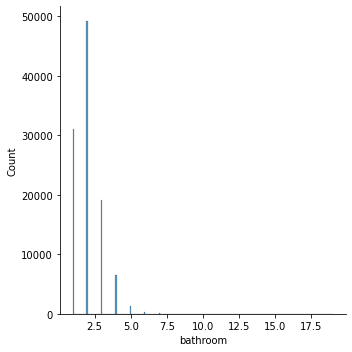

In [173]:
sns.displot(x="bathroom", data=data)

Como bathroom se convirtio en continua hay que sacarla de la lista de categoricas y ponerla en la lista de continuas

In [174]:
categorical_columns = categorical_columns[:-1]
continuous_columns.append('bathroom')

In [175]:
data.describe()

,bedroom,price,area,bathroom
count,107935.000000,107935.000000,107935.000000,107671.000000
mean,2.101783,22391.453016,1294.550127,2.070975
std,0.986398,18149.665824,1115.436432,0.977349
min,1.000000,1.000000,3.000000,1.000000
25%,1.000000,10000.000000,650.000000,1.000000
50%,2.000000,18000.000000,1000.000000,2.000000
75%,3.000000,30000.000000,1450.000000,3.000000
max,15.000000,99999.000000,19800.000000,19.000000


### En la variable precio se observan valores muy extremos, hay que ver cuantos son

<AxesSubplot:xlabel='price'>

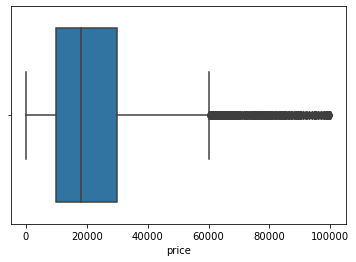

In [182]:
plt.figure()
sns.boxplot(x='price', data=data)

In [183]:
len(data[(data['price'] < 1000) | (data['price'] > 600000)])

9154

In [184]:
data = data[(data['price'] > 1000)]

<AxesSubplot:xlabel='price'>

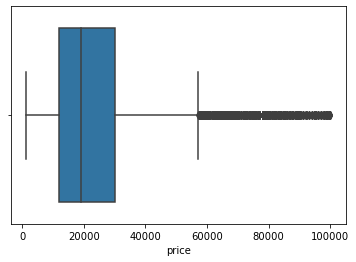

In [185]:
plt.figure()
sns.boxplot(x='price', data=data)

### Analisis bivariante

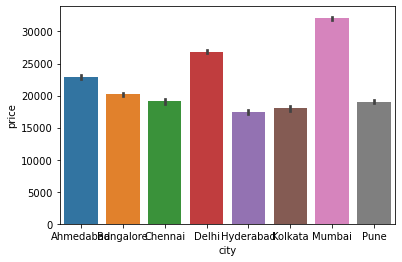

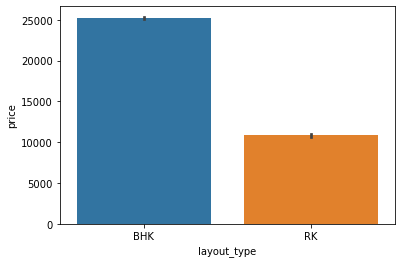

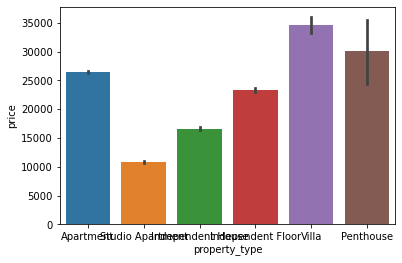

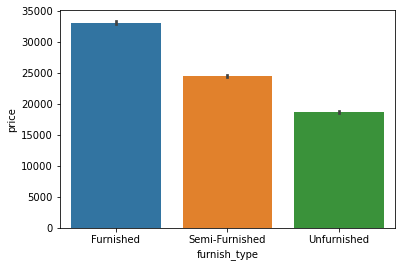

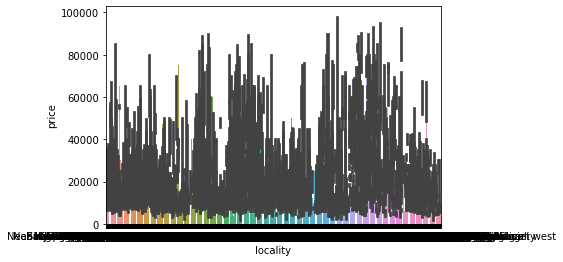

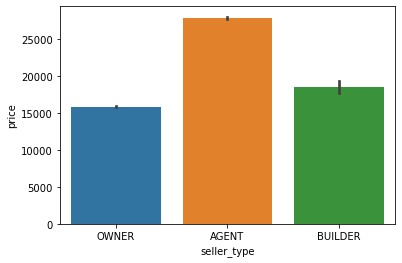

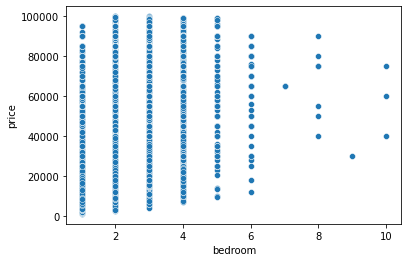

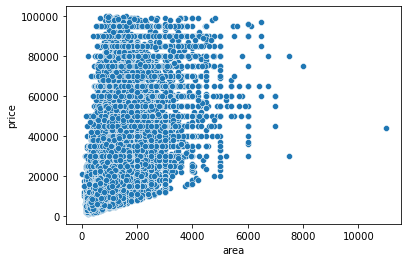

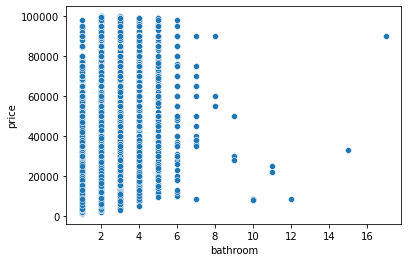

In [186]:
for column in categorical_columns:
    plt.figure()
    df = data[['price', column]].groupby(column).mean().reset_index().sort_values(by='price')
    sns.barplot(x=column,y='price',data=data)
    
for column in continuous_columns:
    plt.figure()
    sns.scatterplot(x=column,y='price',data=data)

### Encodear las variables categoricas

In [187]:
catboost_encoder = ce.CatBoostEncoder(cols=categorical_columns)
data_encoded = catboost_encoder.fit_transform(data,data[target])
data_encoded

,seller_type,bedroom,layout_type,property_type,locality,price,area,furnish_type,bathroom,city
0,24466.191990,2.0,24466.191990,24466.191990,24466.191990,20000.0,1450.0,24466.191990,2.0,24466.191990
1,22233.095995,1.0,24466.191990,24466.191990,24466.191990,7350.0,210.0,24466.191990,1.0,22233.095995
2,17272.063997,3.0,22233.095995,22233.095995,24466.191990,22000.0,1900.0,24466.191990,3.0,17272.063997
3,18454.047998,2.0,22155.397330,24466.191990,24466.191990,13000.0,1285.0,15908.095995,2.0,18454.047998
4,17363.238398,2.0,19866.547998,18733.095995,24466.191990,18000.0,1600.0,22233.095995,2.0,17363.238398
...,...,...,...,...,...,...,...,...,...,...
196833,15876.120603,1.0,25256.089477,26446.393834,16131.475216,13250.0,650.0,24430.800833,1.0,19050.187417
196834,15876.024316,1.0,10848.509923,10848.509923,19659.286627,7000.0,350.0,18679.596673,1.0,19049.780643
196835,15875.698889,1.0,25255.960888,26446.207639,19931.695469,8500.0,389.0,24430.581093,1.0,19048.935638
196836,27875.536202,1.0,25255.781428,26445.954430,18847.320496,16500.0,670.0,24430.268011,2.0,19048.195932


### Correlacion

<AxesSubplot:>

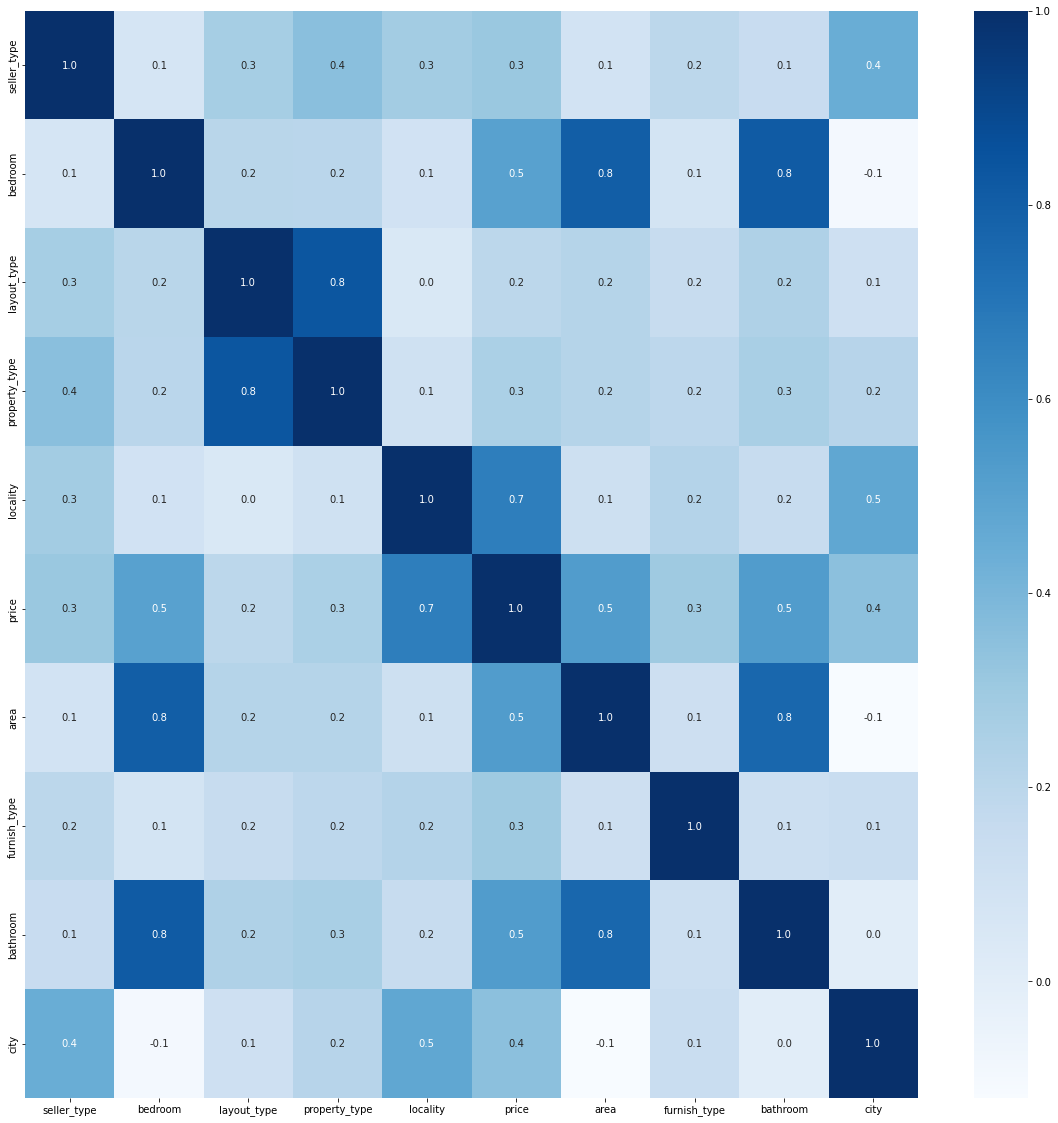

In [188]:
correlation_matrix = data_encoded.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')

### Analisis de outliers

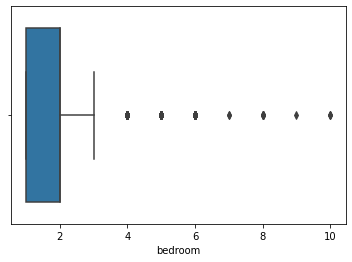

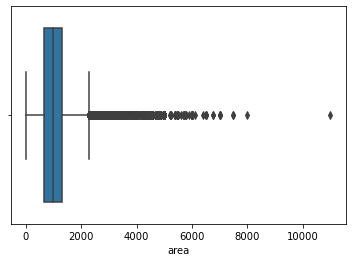

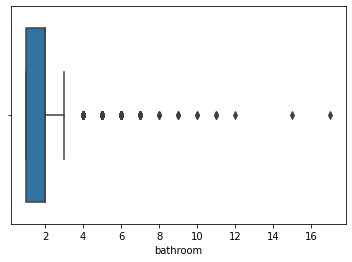

In [189]:
for column in continuous_columns:
    plt.figure()
    sns.boxplot(x=column, data=data)

### Analisis de dimensionalidad

In [190]:
X = data_encoded.drop(target,axis=1)
y = data_encoded[target]

In [191]:
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [193]:
sel_ridge = SelectFromModel(Ridge(), threshold = 0.009)
sel_ridge.fit(X_train, y_train)

SelectFromModel(estimator=Ridge(), threshold=0.009)

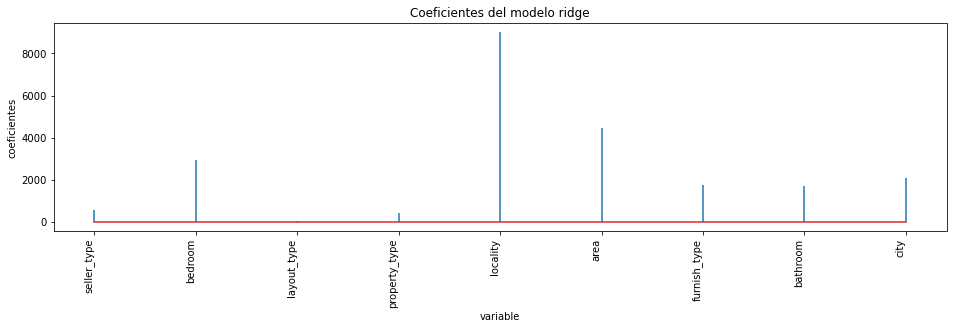

In [194]:
df_coeficientes = pd.DataFrame(
    {'predictor': X_train.columns,
     'coef': sel_ridge.estimator_.coef_.flatten()}
)

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [195]:
selected_features = X_train.columns[sel_ridge.get_support()]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_features)))

total features: 9
selected features: 9


### PCA

In [196]:
pca = PCA(n_components='mle')

pca.fit(X_train[selected_features])
X_train_pca = pca.transform(X_train[selected_features])
X_test_pca = pca.transform(X_test[selected_features])
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)
X_train_pca.columns = ['PCA_'+str(i) for i in X_train_pca.columns]
X_test_pca.columns = ['PCA_'+str(i) for i in X_test_pca.columns]

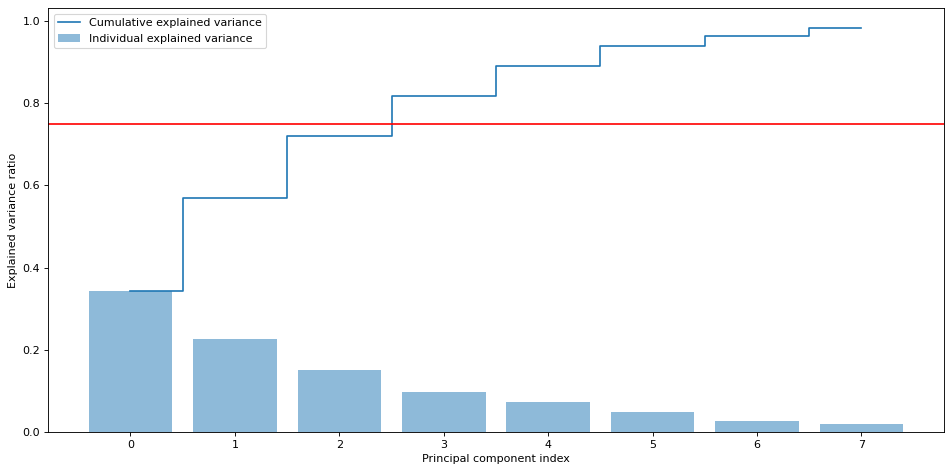

In [197]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

threshold = 0.75
plt.figure(figsize=(12, 6), dpi=80)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=threshold, color='r', linestyle='-')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [198]:
print(f'Numero de features: {X_train_pca.shape[1]}')

Numero de features: 8


#### Probar un modelo de regresion con y sin PCA

In [206]:
reg_pca = LinearRegression()
reg_pca.fit(X_train_pca,y_train)

LinearRegression()

In [207]:
metrics.r2_score(reg_pca.predict(X_test_pca),y_test)

0.563807645559435

In [208]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [209]:
metrics.r2_score(reg.predict(X_test),y_test)

0.5638435794297505

El score es el mismo con y sin PCA

## exportar dataset

In [210]:
data.to_csv('./data/data.csv',index=False)